In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [2]:
def generate_MoG_data(num_data, mean, covs, weights):
    k = len(weights)
    data = []
    for i in np.arange(num_data):
        # This generates the cluster labels, weightage in favour of which cluster to have more data points.
        # for the chosen init_weights, cluster 1 will have more representation in for loop
        k = np.random.choice(len(weights), 1, p = weights)[0]

        # Now generate single data point with multivariate characteristics based on k value.
        x = np.random.multivariate_normal(mean[k], covs[k])
        data.append(x)
    return data

In [3]:
# Model parameters
init_means = [
    [5, 0], # mean of cluster 1
    [1, 1], # mean of cluster 2
    [0, 5]  # mean of cluster 3
]
init_covariances = [
    [[.5, 0.], [0, .5]], # covariance of cluster 1 : Relatively tighter cluster than 2.
    [[.92, .38], [.38, .91]], # covariance of cluster 2 : More spread out cluster, but more number of points due to weightage, also has cross correlation hence orientation diff than others.  If off-diagonal elements are +ve, implies +ve slope oriented points, if 0 circular orientation, if -ve, then -ve sloped orientation
    [[.5, 0.], [0, .5]]  # covariance of cluster 3 : Tighter than 2
]
init_weights = [1/4., 1/2., 1/4.]  # weights of each cluster

np.random.seed(4)
data = generate_MoG_data(100, init_means, init_covariances, init_weights)

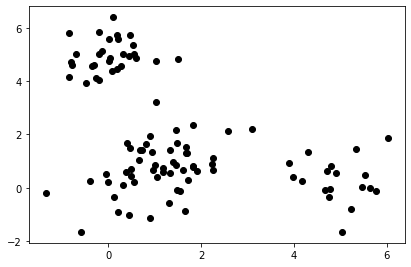

In [4]:
plt.figure()
d = np.vstack(data)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [5]:
## Required for plotting 
def bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0,
                     mux=0.0, muy=0.0, sigmaxy=0.0):
    """
    Bivariate Gaussian distribution for equal shape *X*, *Y*.
    See `bivariate normal
    <http://mathworld.wolfram.com/BivariateNormalDistribution.html>`_
    at mathworld.
    """
    Xmu = X-mux
    Ymu = Y-muy

    rho = sigmaxy/(sigmax*sigmay)
    z = Xmu**2/sigmax**2 + Ymu**2/sigmay**2 - 2*rho*Xmu*Ymu/(sigmax*sigmay)
    denom = 2*np.pi*sigmax*sigmay*np.sqrt(1-rho**2)
    return np.exp(-z/(2*(1-rho**2))) / denom

def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data],'ko') # data

    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])  # The std dev in x axis
        sigmay = np.sqrt(cov[1][1])  # The std dev in y axis
        sigmaxy = cov[0][1]/(sigmax*sigmay)   # Cross-covariance
        Z = bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

In [6]:
def log_sum_exp(Z):
    """ Compute log(\sum_i exp(Z_i)) for some array Z."""
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

def loglikelihood(data, weights, means, covs):
    """ Compute the loglikelihood of the data for a Gaussian mixture model with the given parameters. """
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            
            # Compute (x-mu)^T * Sigma^{-1} * (x-mu)
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            # Compute loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        # Increment loglikelihood contribution of this data point across all clusters
        ll += log_sum_exp(Z)
        
    return ll

In [7]:
def EM(data, init_means, init_covariances, init_weights, maxiter = 1000, thresh = 1e-4):

    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]

    num_clusters = len(means)
    num_dim = len(data[0])
    num_data = len(data)

    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]

    for i in range(maxiter):
        iteration = str(f"iteration:{i}")
        # plot_contours(data, means, covariances, iteration)
        # plt.show()
        # if i % 5 == 0:
        #     print("Iteration %s" % i)
        
        # E Step : Estimate cluster sesponsibilities for each data given parameters
        for j in range(num_data):
            for k in range(num_clusters):
                resp[j, k] = weights[k] * multivariate_normal.pdf(data[j], means[k], covariances[k])
        row_sums = resp.sum(axis=1)[:, np.newaxis]
        resp = resp / row_sums # Ensure a data-point has total represenation to 1 : normalize over all possible cluster assignments

        # M-step : Estimate maximum likelihood : Update parameters given responsibilites
        counts = np.sum(resp, axis=0) # Total reps for a cluster in all data
        for k in range(num_clusters):
        
            ## Updating Weights
            weights[k] = counts[k]/num_data # This updates the weights based on new responisbility. With more reps, the cluster weights inc
        
            ## Updating Means
            ### For a cluster, go over each data and find the fraction of its representation belonging to that cluster based on responsibility. Divide them by cluster count to normalization
            weighted_sum = 0
            for j in range(num_data):
                weighted_sum += resp[j,k]*data[j]
            means[k] = weighted_sum/counts[k]

            ## Updating Covariances
            weighted_sum = np.zeros((num_dim, num_dim))  # Init based on input dimension : bcos covariance is about how it varies wrt other input features
            for j in range(num_data):
                weighted_sum += resp[j,k] * np.outer(data[j] - means[k], data[j] - means[k])
            covariances[k] = weighted_sum/counts[k]
    
        # Compute the loglikelihood at this iteration
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        
        # Check for convergence in log-likelihood and store
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest

        
    if i % 5 != 0:
        print("Iteration %s" % i)
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}
    
    return out

In [8]:
## Re-assigning the means randomly
init_means = [
    [1, 2], # mean of cluster 1
    [1, 1], # mean of cluster 2
    [2, 1]  # mean of cluster 3
]

In [9]:
out = EM(data, init_means, init_covariances, init_weights, maxiter = 400, thresh = 1e-4)

Iteration 11


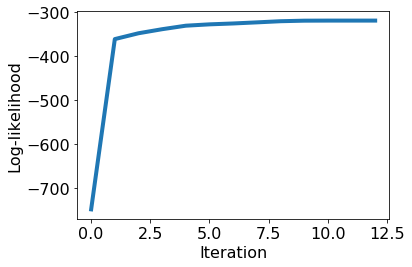

In [10]:
loglikelihoods = out['loglik']
plt.plot(range(len(loglikelihoods)), loglikelihoods, linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()
# Log-likelihood increases with iterations and saturates

## Image Clustering with EM Model


In [11]:
images = pd.read_csv(r'Data\images.csv', index_col = 0)
images['rgb'] = images[['red', 'green', 'blue']].values.tolist()
images.head()

,path,image,folder,red,green,blue,rgb
0,/data/coursera/images/sunsets/ANd9GcSN4TPL6_Xo...,Height: 194px\nWidth: 259px\nChannels: 3\n,sunsets,0.403223,0.254570,0.297392,"[0.4032234842076981, 0.2545700932661306, 0.297..."
1,/data/coursera/images/sunsets/ANd9GcQeme67tTCc...,Height: 194px\nWidth: 259px\nChannels: 3\n,sunsets,0.556835,0.246377,0.039541,"[0.5568352144946861, 0.24637719918003426, 0.03..."
2,/data/coursera/images/sunsets/ANd9GcSAb2GMlHYI...,Height: 183px\nWidth: 275px\nChannels: 3\n,sunsets,0.530449,0.114891,0.072064,"[0.5304492672627918, 0.11489094324391455, 0.07..."
3,/data/coursera/images/sunsets/ANd9GcRs4-CSokZQ...,Height: 183px\nWidth: 276px\nChannels: 3\n,sunsets,0.457634,0.194312,0.616880,"[0.4576339546457987, 0.19431157564148252, 0.61..."
4,/data/coursera/images/sunsets/ANd9GcQov2JpsVI0...,Height: 177px\nWidth: 284px\nChannels: 3\n,sunsets,0.329559,0.231696,0.202149,"[0.3295588769197104, 0.2316961554816185, 0.202..."


In [13]:
np.random.seed(1)

# Initalize parameters
init_means = [images['rgb'][x] for x in np.random.choice(len(images), 4, replace=False)]
cov = np.diag([images['red'].var(), images['green'].var(), images['blue'].var()])
init_covariances = [cov, cov, cov, cov]
init_weights = [1/4., 1/4., 1/4., 1/4.]

# Convert rgb data to numpy arrays
img_data = [np.array(i) for i in images['rgb']]  


# Run our EM algorithm on the image data using the above initializations. 
# This should converge in about 125 iterations
out = EM(img_data, init_means, init_covariances, init_weights)

Iteration 118


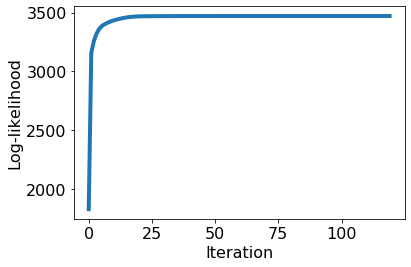

In [15]:
ll = out['loglik']
plt.plot(range(len(ll)),ll,linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()  

In [16]:
# Predictions

means = out['means']
covariances = out['covs']
rgb = images['rgb']

N = len(images)
K = len(means)

assignments = [0]*N
probs = [0]*N
p = np.zeros((N, K))
for i in range(N):
    # Compute the score of data point i under each Gaussian component:
    # p = np.zeros(K)
    for k in range(K):
        # YOUR CODE HERE (Hint: use multivariate_normal.pdf and rgb[i])
        p[i][k] = multivariate_normal.pdf(rgb[i], means[k], covariances[k])
        
    # Compute assignments of each data point to a given cluster based on the above scores:
    # YOUR CODE HERE
    assignments[i] = np.argmax(p[i])
    
    # For data point i, store the corresponding score under this cluster assignment:
    # YOUR CODE HERE
    probs[i] = np.amax(p[i])

In [17]:
images.head()

,path,image,folder,red,green,blue,rgb
0,/data/coursera/images/sunsets/ANd9GcSN4TPL6_Xo...,Height: 194px\nWidth: 259px\nChannels: 3\n,sunsets,0.403223,0.254570,0.297392,"[0.4032234842076981, 0.2545700932661306, 0.297..."
1,/data/coursera/images/sunsets/ANd9GcQeme67tTCc...,Height: 194px\nWidth: 259px\nChannels: 3\n,sunsets,0.556835,0.246377,0.039541,"[0.5568352144946861, 0.24637719918003426, 0.03..."
2,/data/coursera/images/sunsets/ANd9GcSAb2GMlHYI...,Height: 183px\nWidth: 275px\nChannels: 3\n,sunsets,0.530449,0.114891,0.072064,"[0.5304492672627918, 0.11489094324391455, 0.07..."
3,/data/coursera/images/sunsets/ANd9GcRs4-CSokZQ...,Height: 183px\nWidth: 276px\nChannels: 3\n,sunsets,0.457634,0.194312,0.616880,"[0.4576339546457987, 0.19431157564148252, 0.61..."
4,/data/coursera/images/sunsets/ANd9GcQov2JpsVI0...,Height: 177px\nWidth: 284px\nChannels: 3\n,sunsets,0.329559,0.231696,0.202149,"[0.3295588769197104, 0.2316961554816185, 0.202..."


In [18]:
prediction = pd.DataFrame(p, columns=['a', 'b', 'c', 'd'])
prediction['assignment'] = assignments
prediction['True_Assignment'] = images['folder']
prediction['prob'] = probs

prediction.head(10)
## The values need to normalized to be summing to 1 across rows

,a,b,c,d,assignment,True_Assignment,prob
0,1.853411e-06,7.466024e-11,1.107665e-01,16.285518,3,sunsets,16.285518
1,1.689561e-20,6.327592e-16,9.959575e-14,7.375461,3,sunsets,7.375461
2,1.152475e-23,8.328384e-50,3.227843e-19,2.579831,3,sunsets,2.579831
3,5.007746e-53,5.483952e-104,1.080501e-11,0.007651,3,sunsets,0.007651
4,6.919561e-10,1.507621e-02,3.007088e+00,11.637525,3,sunsets,11.637525
5,3.481404e-07,7.920951e-04,4.754546e-01,25.581285,3,sunsets,25.581285
6,2.159559e-14,5.631268e-01,2.538091e+00,9.929105,3,sunsets,9.929105
7,6.671388e-01,2.685666e-05,8.824901e-01,9.259869,3,sunsets,9.259869
8,1.920172e-17,9.054981e-11,1.806420e-10,11.055761,3,sunsets,11.055761
9,8.241605e-06,6.907259e+01,7.075784e+01,15.781398,2,sunsets,70.757839


In [19]:
## The number doesnt look that promising though
pd.crosstab(prediction['assignment'], prediction['True_Assignment'])

True_Assignment,cloudy_sky,rivers,sunsets,trees_and_forest
assignment,,,,
0,101,2,7,4
1,144,176,39,66
2,18,157,29,195
3,25,24,287,54


# Notes : EM Algorithm

* Initialize parameters : weights, mean, covariances for the clusters
* E - Step : Estimate responsibilities of clusters in individual data
    * In the responsibilities matrix:
        1. each row will sum to one : indicating a data point has total representation summing to 1
        2. each column represents clusters, they will sum to be larger than 1, in that case that cluster is dominant or has more data
* M - Step : Estimate parameters for given responsibilities
    * Update weights:
        1. Cluster Weights are updated by normalizing over number of data. 
    * Update means:
        1. For each data, sum the fraction of representation  in each cluster
        2. Normalize that resp count of cluster to get updated cluster means
    * Update covariances:
        1. Similar to updating mean, but with diff formulation
* Convergence criteria is wrt iterations or Convergence of likelihood.
